This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

In [1]:
import tensorflow
from tensorflow.keras.datasets.fashion_mnist import load_data
#fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = load_data()

4423680/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [2]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [3]:
print(train_images.shape)
len(train_labels)

(60000, 28, 28)


60000

In [4]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [5]:
test_images.shape

(10000, 28, 28)

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

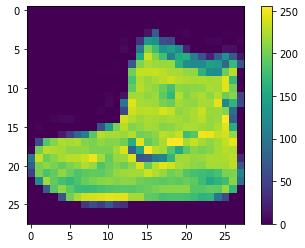

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [7]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

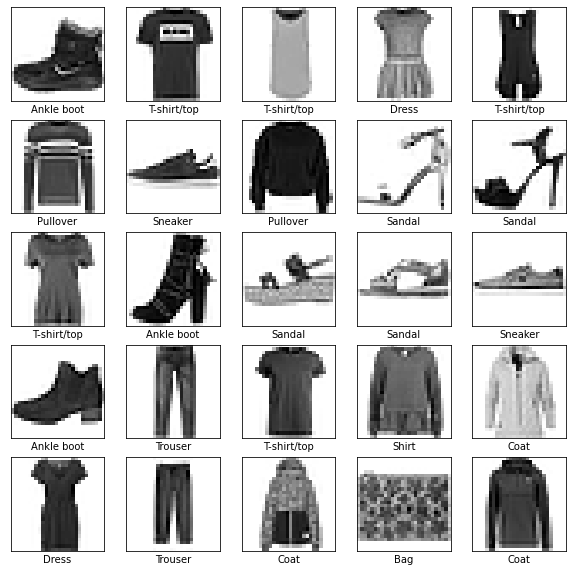

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [9]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

**The** first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [10]:
import tensorflow as tf
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the `model.fit` method—so called because it "fits" the model to the training data:

In [11]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5009 - accuracy: 0.8243
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3754 - accuracy: 0.8661
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3369 - accuracy: 0.8772
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3128 - accuracy: 0.8856
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2958 - accuracy: 0.8909
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2813 - accuracy: 0.8961
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2676 - accuracy: 0.9020
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2564 - accuracy: 0.9053
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2465 - accuracy: 0.9079
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.237

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [12]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3358 - accuracy: 0.8835

Test accuracy: 0.8834999799728394


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

##Add weight regularization
You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* ----L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
* ----L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.



### Applying L2 regularization

In [13]:
from tensorflow.keras import regularizers
model_l2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(10)
])
model_l2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_l2.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6487 - accuracy: 0.8184
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5079 - accuracy: 0.8503
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4815 - accuracy: 0.8551
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4633 - accuracy: 0.8594
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4521 - accuracy: 0.8654
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4410 - accuracy: 0.8653
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4335 - accuracy: 0.8687
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4257 - accuracy: 0.8701
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4227 - accuracy: 0.8714
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.422

In [14]:
test_loss_l2, test_acc_l2 = model_l2.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc_l2)

313/313 - 0s - loss: 0.5021 - accuracy: 0.8430

Test accuracy: 0.8429999947547913


As can be seen above overfitting is removed to some extent from the model but at the cost of performance.

### Add dropouts
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:



In [15]:
from tensorflow.keras import layers
model_dropout = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    keras.layers.Dense(10)
])
model_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_dropout.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7023 - accuracy: 0.7989
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5621 - accuracy: 0.8329
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5387 - accuracy: 0.8387
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5310 - accuracy: 0.8392
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5242 - accuracy: 0.8418
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5188 - accuracy: 0.8425
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5155 - accuracy: 0.8428
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5111 - accuracy: 0.8453
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5111 - accuracy: 0.8453
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.510

In [16]:
test_loss_dropout, test_acc_dropout = model_dropout.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc_dropout)

313/313 - 0s - loss: 0.4859 - accuracy: 0.8584

Test accuracy: 0.8583999872207642


We applied dropouts on the single layer of 128 nodes by making the output of 30% nodes as zeroes, we were able to reduce overfitting to more extent than l2 regularization

### Combined L2 + dropout

In [17]:
from tensorflow.keras import regularizers
model_l2_dropout = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    keras.layers.Dense(10)
])
model_l2_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_l2_dropout.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7807 - accuracy: 0.7720
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6205 - accuracy: 0.8148
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6006 - accuracy: 0.8167
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5883 - accuracy: 0.8190
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5895 - accuracy: 0.8203
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5826 - accuracy: 0.8194
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5854 - accuracy: 0.8196
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5793 - accuracy: 0.8230
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5781 - accuracy: 0.8229
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.580

In [18]:
test_loss_l2_dropout, test_acc_l2_dropout = model_l2_dropout.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc_l2_dropout)

313/313 - 0s - loss: 0.5172 - accuracy: 0.8437

Test accuracy: 0.8436999917030334


### Make predictions

With the model trained, you can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

In [19]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [20]:
predictions[0]

array([1.3519247e-06, 8.9878605e-11, 9.0788417e-09, 2.1594050e-10,
       8.8909133e-07, 2.0029260e-02, 5.5423509e-08, 1.1709724e-02,
       1.6383768e-06, 9.6825713e-01], dtype=float32)

In [21]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [22]:
import numpy as np
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

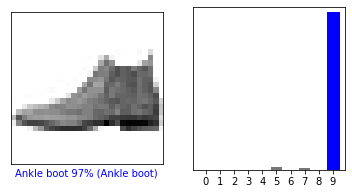

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

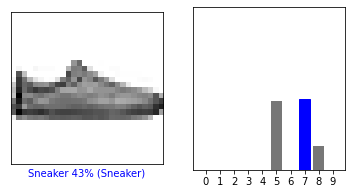

In [24]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


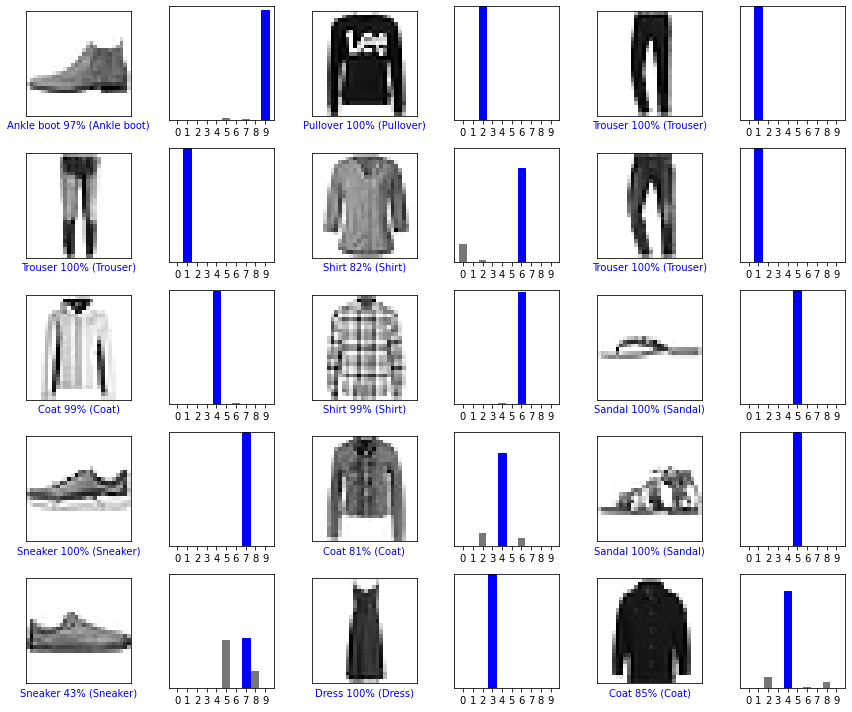

In [25]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
print(class_names)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [26]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [27]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [28]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[1.7433231e-04 6.3100465e-14 9.9951982e-01 9.6153203e-11 1.2477244e-04
  4.3317495e-11 1.8117062e-04 2.3655734e-21 2.9257499e-09 5.6859702e-14]]


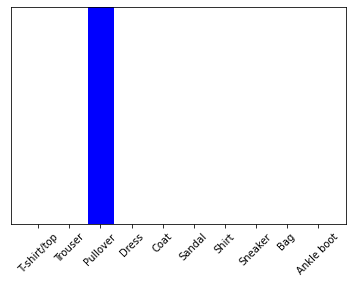

In [29]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

### I hope with this you can start your journey into the world of Deep Learning